In [1]:
import sympy as sp
import networkx as nx
import numpy as np
import tqdm

import matplotlib.pyplot as plt

import linearframework.graph_operations as g_ops
import linearframework.ca_recurrence as ca
import linearframework.linear_framework_results as lfr
import linearframework.generalized_aldous_schepp as gas

The purpose of this notebook is to show and explain how to use this library to quickly and efficiently perform monte-carlo simulations of the interesting quantities of linear framework graphs with random weights (or just with specific weights).

We use the Chabotaev-Ageav recurrence method to calculate the the weights of spanning forests.

We define graphs, then we calculate symbolic formulas for the particular quantities of interest--say, the second moment of the first passage time from vertex $1$ to vertex $3$ on the $k3$ graph.

Then, we use these symbolic formulas to quickly calculate the same quantity on the same graph topology with different edge weights many times.

What facilitates this rapid re-calculation is the representation of graphs as dictionaries.

We initialize graphs with dictionaries of edges to weights.

Edges are tuples containing two strings. Each string is the id of a vertex in the graph.

In [2]:
k3_edge_to_weight = {
    ('1', '2'): 1,
    ('1', '3'): 2,
    ('2', '1'): 3,
    ('2', '3'): 4,
    ('3', '1'): 5,
    ('3', '2'): 6
}

We can turn these dictionaries into networkx graphs if we need to.

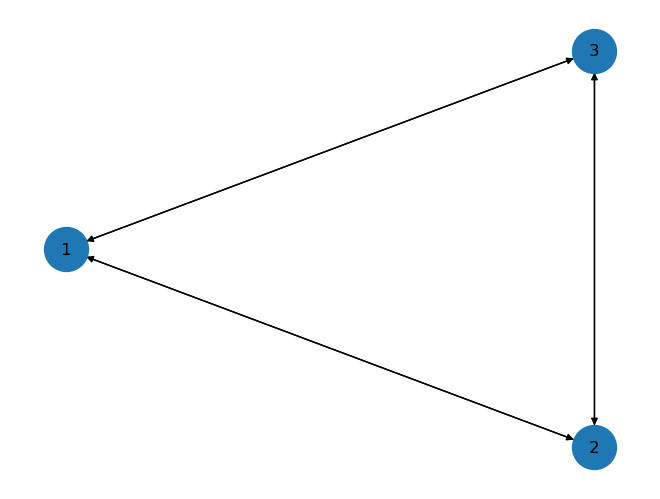

In [3]:
k3 = g_ops.dict_to_graph(k3_edge_to_weight)
nx.draw(k3, pos=nx.shell_layout(k3), with_labels=True, node_size=1000)

But we do not explicitly use networkx graphs in these calculations.

We do need to initialize the symbolic edges.

We initialize these symbols now so that we can easily substitute them for certain values later and evaluate at a point.

In [4]:
k3_edge_to_sym = g_ops.edge_to_sym_from_edge_to_weight(k3_edge_to_weight)

k3_edge_to_sym

{('1', '2'): l_1,
 ('1', '3'): l_2,
 ('2', '1'): l_3,
 ('2', '3'): l_4,
 ('3', '1'): l_5,
 ('3', '2'): l_6}

With these two dictionaries, we can call our functions which calculate quantities.

For transient quantities, we first calculate the formula.
Let's calculate the second moment of the first passage time from vertex $1$ to vertex $3$ on the $k3$ graph.

In [5]:
source = '1'
target = '3'
moment = 2

k3_second_moment_formula = lfr.k_moment_fpt_expression(k3_edge_to_weight, k3_edge_to_sym, source, target, moment)

k3_second_moment_formula

(2*l_1*l_3 + 2*l_1*(l_1 + l_2) + 2*l_1*(l_3 + l_4) + 2*(l_3 + l_4)**2)/(l_1*l_4 + l_2*l_3 + l_2*l_4)**2

Now that we have this formula, we can evaluate it at a point. We currently have a an edge-to-weight dictionary.
To substitute the symbolic edge weights for numbers, we need to make a symbol-to-weight dictionary.

In [6]:
k3_sym_to_weight = g_ops.make_sym_to_weight(k3_edge_to_weight, k3_edge_to_sym)

k3_sym_to_weight

{l_1: 1, l_2: 2, l_3: 3, l_4: 4, l_5: 5, l_6: 6}

and then we can evaluate at a point.

In [7]:
k3_second_moment_formula.subs(k3_sym_to_weight)

31/81

To run a monte-carlo simulation with many sets of random edge weights, we can iteratively make new edge-to-weight dictionaries and evaluate at those points without the need for re-deriving the formula.

The edges are sampled in our usual way--from a uniform distribution on the range $[10^{-3}, \ 10^3]$.

I've packaged this functionality into a nice little function.

The rate of this function scales linearly with the number of edges, so even as the number of edges increases, the function should remain relatively fast. On my laptop, I'm seeing about 180 iterations a second for the k3 graph.

100%|██████████| 1000/1000 [00:06<00:00, 150.89it/s]


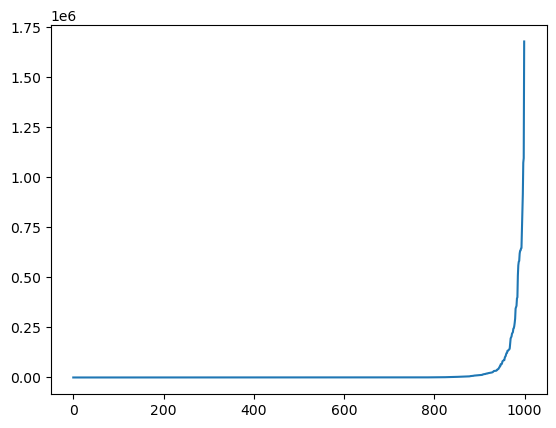

In [8]:
k3_second_moment_datapoints = g_ops.evaluate_at_many_points(k3_edge_to_weight, k3_edge_to_sym, k3_second_moment_formula, 1000)
plt.plot(np.sort(k3_second_moment_datapoints))

plt.show()

I have also developed a method for calculating the generalized randomness parameter ($s_m(G)$).

Let's generate a random directed networkx graph, find the expression for s_m(G) with some source and target, and calculate a number of datapoints.

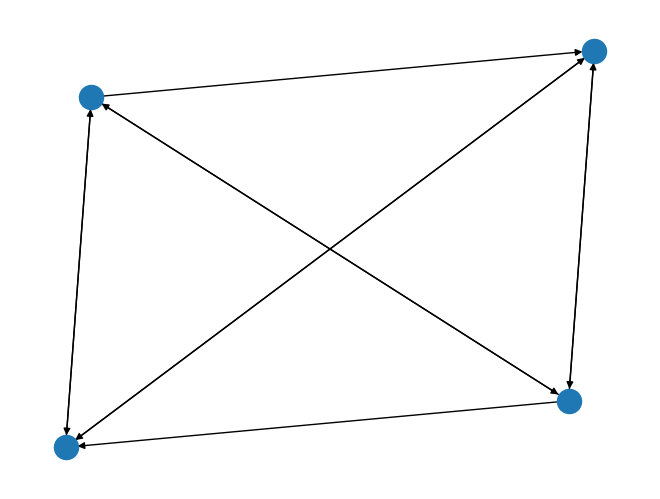

In [9]:
num_vertices = 4
edge_prob = 0.5
r4_graph = nx.fast_gnp_random_graph(num_vertices, edge_prob, directed=True)

nx.draw(r4_graph)

In [10]:
r4_edge_to_weight = g_ops.edges_to_random_weight_dict(r4_graph.edges())
r4_edge_to_sym = g_ops.edge_to_sym_from_edge_to_weight(r4_edge_to_weight)

source = '0'
target = '3'
moment = 2

r4_s2_0_3 = gas.generalized_randomness_parameter(r4_edge_to_weight, r4_edge_to_sym, source, target, moment)

print(type(r4_s2_0_3))

num_samples = 1000

r4_s2_0_3_datapoints = g_ops.evaluate_at_many_points(r4_edge_to_weight, r4_edge_to_sym, r4_s2_0_3, num_samples)


<class 'sympy.core.mul.Mul'>


100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s]


I've also written a handy function calculating the Guzman-Alca equation, allowing us to easily test our bound.

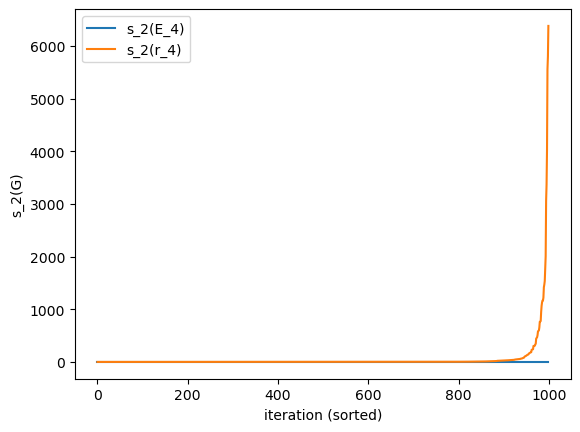

In [11]:
s2_e4 = gas.guzman_alca_equation(num_vertices, moment)

s2_e4_array = np.ones(num_samples) *s2_e4

plt.plot(s2_e4_array, label="s_2(E_4)")
plt.plot(np.sort(r4_s2_0_3_datapoints), label=('s_2(r_4)'))
plt.legend()
plt.ylabel('s_2(G)')
plt.xlabel('iteration (sorted)')
plt.show()

The interface to calculate the steady state probabilities is the same as the other quantities. In the transient quantities, we get the quantity to a specific target vertex, the steady-state probability is a little different. We calculate all steady-state probabilities at once. The output of the function is a dictionary of vertex id to the symbolic expression of its steady-state probability.

We also have two methods of calculating the steady states. The first uses the first-minors matrix tree theorem to find the steady states (`steady_states_from_sym_lap()`), which is much faster, and the second uses the Chabotarev-Agaev recurrence (`steady_states_from_Q_n_minus_1()`).

The `evaluate_at_many_points()` method also works just as well here as with the transient quantities--you just need to pick which state you want to evaluate.

In [12]:
k3_steady_states_from_lap = lfr.steady_states_from_sym_lap(k3_edge_to_weight, k3_edge_to_sym)

k3_steady_states_from_lap

{'1': (l_3*l_5 + l_3*l_6 + l_4*l_5)/(l_1*l_4 + l_1*l_5 + l_1*l_6 + l_2*l_3 + l_2*l_4 + l_2*l_6 + l_3*l_5 + l_3*l_6 + l_4*l_5),
 '2': (l_1*l_5 + l_1*l_6 + l_2*l_6)/(l_1*l_4 + l_1*l_5 + l_1*l_6 + l_2*l_3 + l_2*l_4 + l_2*l_6 + l_3*l_5 + l_3*l_6 + l_4*l_5),
 '3': (l_1*l_4 + l_2*l_3 + l_2*l_4)/(l_1*l_4 + l_1*l_5 + l_1*l_6 + l_2*l_3 + l_2*l_4 + l_2*l_6 + l_3*l_5 + l_3*l_6 + l_4*l_5)}

In [13]:
k3_steady_states_from_Q_nm1 = lfr.steady_states_from_Q_n_minus_1(k3_edge_to_weight, k3_edge_to_sym)

k3_steady_states_from_Q_nm1

{'1': (-l_4*l_6 + (-l_1 - l_2)*(l_3 + l_4 + l_5 + l_6) + (l_1 + l_2)*(l_3 + l_4 + l_5 + l_6)/2 + (l_3 + l_4)*(l_1 + l_2 + l_5 + l_6)/2 + (l_5 + l_6)*(l_1 + l_2 + l_3 + l_4)/2)/(-l_1*l_3 - l_2*l_5 - l_4*l_6 + (-l_1 - l_2)*(l_3 + l_4 + l_5 + l_6) + 3*(l_1 + l_2)*(l_3 + l_4 + l_5 + l_6)/2 + (-l_3 - l_4)*(l_1 + l_2 + l_5 + l_6) + 3*(l_3 + l_4)*(l_1 + l_2 + l_5 + l_6)/2 + (-l_5 - l_6)*(l_1 + l_2 + l_3 + l_4) + 3*(l_5 + l_6)*(l_1 + l_2 + l_3 + l_4)/2),
 '2': (-l_2*l_5 + (l_1 + l_2)*(l_3 + l_4 + l_5 + l_6)/2 + (-l_3 - l_4)*(l_1 + l_2 + l_5 + l_6) + (l_3 + l_4)*(l_1 + l_2 + l_5 + l_6)/2 + (l_5 + l_6)*(l_1 + l_2 + l_3 + l_4)/2)/(-l_1*l_3 - l_2*l_5 - l_4*l_6 + (-l_1 - l_2)*(l_3 + l_4 + l_5 + l_6) + 3*(l_1 + l_2)*(l_3 + l_4 + l_5 + l_6)/2 + (-l_3 - l_4)*(l_1 + l_2 + l_5 + l_6) + 3*(l_3 + l_4)*(l_1 + l_2 + l_5 + l_6)/2 + (-l_5 - l_6)*(l_1 + l_2 + l_3 + l_4) + 3*(l_5 + l_6)*(l_1 + l_2 + l_3 + l_4)/2),
 '3': (-l_1*l_3 + (l_1 + l_2)*(l_3 + l_4 + l_5 + l_6)/2 + (l_3 + l_4)*(l_1 + l_2 + l_5 + l_6)/2 + 

notice that all of these expressions are the same no matter which method used to derive them.

In [14]:
for key in k3_steady_states_from_lap.keys():
    print(sp.expand(k3_steady_states_from_lap[key] - k3_steady_states_from_Q_nm1[key]))

0
0
0
